In this notebook we will use the HuggingFace [Evaluate](https://huggingface.co/docs/evaluate/index) library, which makes it easy to compute different evaluation metrics.

In [ ]:
import evaluate

### Perplexity

In generative language modeling, perplexity is a measure of how well a language model has done in terms of learning to generate text conditioned on a given context from a true corpus. For a sequence of tokens $X = (x_1, \ldots x_n)$ perplexity is computed

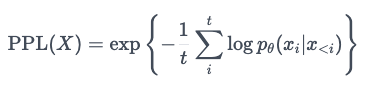

where $\log P_{\theta}(x_i \vert x_{<i})$ is the log-likelihood of the $i$-th token conditioned on the preceding tokens, as estimated by the model with parameters $\theta$. For models with fixed input length (like OPT) and given a set of texts, the texts are broken into sliding windows of maximum context and the log-likelihood of next words are iteratively estimated by the model. Then the results are averaged over all tokens.

In some ways, perplexity can (sort of) be thought of as the "number of tokens the model is choosing between at a given generative step. Ideally, perplexity is 1 and the lower the value the better.

Below, we'll measure perplexity of GPT2 on a very small set of four texts, simply for demonstration. The metric constructs a perplexity for each input along with an average perplexity over the corpus itself.

In [ ]:
text_1 = """Precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances, while recall (also known as sensitivity) is the fraction of relevant instances that were retrieved. Both precision and recall are therefore based on relevance."""  # noqa: E501
text_2 = """The Barkley Marathons is an ultramarathon trail race held each year in Frozen Head State Park in Morgan County, Tennessee. The course, which varies from year to year, consists of five loops of the 20 miles course for a total of 100 miles (160 km). Some racers have claimed that it is longer. If runners complete three laps (60 miles, 97 km) this is known as the "fun run". Generally two of the first four loops are run clockwise and the other two counterclockwise. If multiple runners begin a fifth loop then they are sent off in alternating directions. The race is limited to a 60-hour period from the start of the first loop, and takes place in March or early April of each year."""  # noqa: E501
text_3 = """The NCAA Division I men's basketball tournament, branded as NCAA March Madness and commonly called March Madness, is a single-elimination tournament played each spring in the United States, currently featuring 68 college basketball teams from the Division I level of the National Collegiate Athletic Association (NCAA), to determine the national champion. The tournament was created in 1939 by the National Association of Basketball Coaches, and was the idea of Ohio State coach Harold Olsen. Played mostly during March, it has become one of the most popular annual sporting events in the United States."""  # noqa: E501

perplexity = evaluate.load("perplexity", module_type="metric")
results = perplexity.compute(predictions=[text_1, text_2, text_3], model_id="gpt2")
results

### Exact Match (EM)

For comparison of reference and prediction text in natural language generation, exact match is the simplest metric to consider and very much the least flexible and informative. It is computed, more or less, as it sounds. It determines whether the generated text exactly matches a reference text. The HuggingFace implementation allows you to soften the matching, but, in general, exact matching is still required.

In [ ]:
exact_match = evaluate.load("exact_match")
results = exact_match.compute(
    predictions=["cat?", "theater", "yelling", "agent", "Hello there!"],
    references=["the cat", "theater", "YELLING", "agent007", "hello there"],
    ignore_case=True,
    ignore_punctuation=True,
)
results

### METEOR ([Reference](https://aclanthology.org/W05-0909.pdf))

Metric for Evaluation of Translation with Explicit ORdering (METEOR) computes a score for this matching using a combination of unigram-precision, unigram-recall, and a measure of fragmentation that is designed to directly capture how well-ordered the matched words in the machine translation are in relation to the reference. As an example, We'll consider

* `Reference text`: "I like to run on trails in the Summer for exercise"
* `Generated text`: "I like to exercise on trails today" 

__NOTE__: The default tokenizer is just whitespace.

__NOTE__: When multiple prediction, reference pairs are asssessed, the score is the average.

For a reference and predicted text, METEOR first computes two scores:

1) Unigram recall ($R$): $$\frac{\text{# unigrams occuring in both texts}}{\text{# unigrams in reference text}}$$
2) Unigram precision ($P$): $$\frac{\text{# unigrams occuring in both texts}}{\text{# unigrams in predicted text}}$$

For our example $R = 6/11$ and $P= 6/7$

The harmonic mean is used to combine $R$ and $P$ as $F$-score:
$$\frac{1}{F} = \frac{\alpha}{R} + \frac{1 - \alpha}{P} \Longrightarrow F = \frac{PR}{(1-\alpha)\cdot R + \alpha \cdot P}.$$ 

Note that the default for HuggingFace is $\alpha=0.9$ which matches the formulation in the original paper (with some algebra). In our example this yields 0.5660.

The matched unigrams are then "chunked" in the sense that adjacent matched unigrams that are also adjacent in the reference are combined into chunks such that the least number of chunks are created. The matched unigrams are (I, like, to, on, trails, exercise) and our chunks are [(I, like, to), (on, trails), (exercise)], 

For $c$ the number of chunks and $\mu_m$ the number of matched unigrams, the penalty is computed $$p = 0.5\left(\frac{c}{\mu_m} \right)^3.$$

In our example, this means that $p = 0.0625$.

The final score is then computed $M = F(1-p)$ = (1-0.0625)(0.5660) = 0.53066



In [ ]:
meteor = evaluate.load("meteor")
references = ["I like to run on trails in the Summer for exercise"]
predictions = ["I like to exercise on trails today"]
results = meteor.compute(predictions=predictions, references=references)
results

In the HuggingFace implementation, we can change: 
* $\gamma$: which is the coefficient in calculating $p$ (default 0.5)
* $\beta$, the exponent in calculating $p$ (default 3.0)
* $\alpha$, the ratio of perplexity to recall in the harmonic mean calculation above (default 0.9)

### ROUGE ([Reference](https://aclanthology.org/W04-1013.pdf))
The ROUGE score is often used, for example, when comparing generated summaries with some human reference summary in a dataset. It is similar in use to the BLEU score discussed below. 

We'll consider the 
* `Reference text`: "I like to run on trails in the Summer for exercise"
* `Generated text`: "I like to exercise on trails today" 

__NOTE__: The default tokenizer is just whitespace

__NOTE__: When multiple prediction, reference pairs are asssessed, the score is the average

#### ROUGE-1
ROUGE-1 Scores are Unigram (single token) based and have two subcomponents.

ROUGE-1 - recall: $$\frac{\sum_{\text{unigram in ref}} \text{overlap}(\text{unigram})}{\text{# unigrams in ref}}$$

* Denominator (total unigrams in reference) : 11 
* Numerator (matching unigrams from prediction) : 6 (I, like, to, exercise, on, trails)

ROUGE-1 - precision: $$\frac{\sum_{\text{unigram in ref}} \text{overlap}(\text{unigram})}{\text{# unigrams in pred}}$$

* Denominator (total unigrams in prediction) : 7 
* Numerator (matching unigrams from reference) : 6 (I, like, to, exercise, on, trails)

The reported value is the ROUGE-1 F1 score: $$\frac{2 \times \text{recall} \times \text{precision}}{\text{recall} + \text{precision}}.$$

2*(6/11)*(6/7)/((6/11) + (6/7)) = 2/3

In [ ]:
rouge = evaluate.load("rouge")
references = ["I like to run on trails in the Summer for exercise"]
predictions = ["I like to exercise on trails today"]
results = rouge.compute(
    predictions=predictions,
    references=references,
    rouge_types=["rouge1"],
)
results

#### ROUGE-2

ROUGE-2 Scores are bigram based (token pairs)

ROUGE-2 recall: $$\frac{\sum_{\text{bigram in ref}} \text{overlap}(\text{bigram})}{\text{# bigram in ref}}$$

* Denominator (total bigram in reference) : 10
* Numerator (matching bigrams from prediction) : 3 ((I, like), (like, to), (on, trails))

ROUGE-2 precision: $$\frac{\sum_{\text{bigram in ref}} \text{overlap}(\text{bigram})}{\text{# bigram in pred}}$$

* Denominator (total bigram in prediction) : 6 
* Numerator (matching bigrams from reference) : 3 ((I, like), (like, to), (on, trails))

The reported value is the ROUGE-2 F1 score: 2*(3/10)*(3/6)/((3/10) + (3/6)) = 0.375

In [ ]:
rouge = evaluate.load("rouge")
references = ["I like to run on trails in the Summer for exercise"]
predictions = ["I like to exercise on trails today"]
results = rouge.compute(
    predictions=predictions,
    references=references,
    rouge_types=["rouge2"],
)
results

### ROUGE-L (or ROUGE-LCS)

ROUGE-L considers the longest (non-necessarily consecutive) common subsequence (LCS) between the reference and prediction sentences. As with the previous versions, it has a precision and recall component. For our example, the LCS is [I, like, to, on, trails]

ROUGE-L - Recall: The ratio  $\frac{\text{number of unigrams in LCS}}{\text{number of unigrams in reference}}$. In our example this is 5/11.

ROUGE-L - Precision: The ratio  $\frac{\text{number of unigrams in LCS}}{\text{number of unigrams in prediction}}$. In our exxample this is 5/7.

The reported value is ROUGE-L F1 Score: $\frac{2*(\text{recall}*\text{precision})}{(\text{recall}+\text{precision})}$.

2*(5/11)*(5/7)/((5/11) + (5/7)) = 0.55555

In [ ]:
rouge = evaluate.load("rouge")
references = ["I like to run on trails in the Summer for exercise"]
predictions = ["I like to exercise on trails today"]
results = rouge.compute(
    predictions=predictions,
    references=references,
    rouge_types=["rougeL"],
)
results

#### ROUGE-L-Sum

This is a variant of ROUGE-L that splits the references and predictions into chunks (by default using \n). For each chunk in the reference, the LCS is computed for each chunk in the predictions and the union is taken. The size of that union is taken as the LCS for that chunk and the LCS for each chunk in the reference is summed.

In the example below, the reference has two chunks "I like to run on trails" and "in the Summer for exercise". The LCS for the first is 5 (I, like, to, on, trails). The LCS for the second chunk is 2 (excercise and today) one from each chunk of predictions.

* Recall: $\frac{\sum_{\text{reference chunk} i} LCS_i}{\text{number of unigrams in reference}}$. In this case 7/12.
* Precision: * Recall: $\frac{\sum_{\text{reference chunk} i} LCS_i}{\text{number of unigrams in predictions}}$ In the example 7/7.

The F1 score is reported $\frac{2*(\text{recall}*\text{precision})}{(\text{recall}+\text{precision})}$.

2*(7/12)*(7/7)/((7/12) + (7/7)) = 0.7368

In [ ]:
rouge = evaluate.load("rouge")
references = ["I like to run on trails \n in the Summer for exercise, today"]
predictions = ["I like to exercise on trails \n today"]
results = rouge.compute(
    predictions=predictions,
    references=references,
    rouge_types=["rougeLsum"],
)
results

### BLEU ([Reference](https://aclanthology.org/P02-1040.pdf))
As with ROUGE scores above, BLEU metrics compare generated text with some human reference text. BLEU is used quite often for machine translation tasks. 

For this example, we'll consider the 
* `Reference text`: "I like to run on trails in the Summer for exercise"
* `Generated text`: "I like to exercise on trails today" 

__NOTE__: The default tokenizer for Hugging Face is `tokenizer_13a`.

__NOTE__: When multiple values are asssessed, the score is the average.

Computing the BLEU score between a reference text and a prediction text has several steps. The first is to compute several n-gram precision, similar to the ROUGE-N scores discussed above. N-gram recall is simply the number of n-tuple consecutive tokens appearch in both the reference and predicted text over the number of n-tuple consecutive tokens in the prediction.

__NOTE__: BLEU also clips the number of occurrences of any unigram to not exceed the largest count of any reference being compared to if required.

By default, BLEU on Huggingface computes precision for 1-, 2-, 3-, and 4-gram variants. For our example, we'll just use up to 3-grams, because we don't have a 4-gram overlap

* $P_1$ = 6/7  (I, like, to, on, trails, exercise)
* $P_2$ = 3/6 ((I, like), (like, to), (on, trails))
* $P_3$ = 1/5 ((I, like, to))

The score is then subject to a brevity penalty (BP) that penalizes predicted texts that are shorter than the reference text. If $c$ and $r$ are the token length of the prediction and reference text respectively, then BP is computed as

$$
\begin{equation*}
\text{BP} = 
\begin{cases}
  1   && \text{if } c > r \\      
  e^{(1 - \frac{r}{c})}  && \text{if } c \leq r
\end{cases}.
\end{equation*}
$$

Then for our example:

* BP = $e^{1-\frac{11}{7}}$ = 0.5647

Finally, we take the geometric mean of our n-gram precisions and scale by BP.

* Score = $\text{BP} \cdot \left( P_1 \cdot P_2 \cdot P_3 \cdot P_4 \right)^{\frac{1}{4}}$ = 0.248991

In [ ]:
bleu = evaluate.load("bleu")
references = ["I like to run on trails in the Summer for exercise"]
predictions = ["I like to exercise on trails today"]
results = bleu.compute(predictions=predictions, references=references, max_order=3)
results

### BERTScore ([Reference](https://arxiv.org/pdf/1904.09675.pdf))

BERTScores are used to compare a generated text to a reference text in natural language generation (NLG) tasks. The reference and prediction texts are tokenized and then fed into a BERT model. Embeddings are taken from an intermediate layer of the pretrained model. The current default model used for english tasks on HuggingFace is RoBERTa-Large. The cosine similarities are computed between all tokens in the reference and prediction text. 

To calculate "recall" or $R_{{\text{BERT}}}$, the reference tokens are matched greedily with prediction tokens based on similarity score.

To calcualte "precision" or $P_{\text{BERT}}$ the prediction tokens are matched greedily with reference tokens based on similarity score.

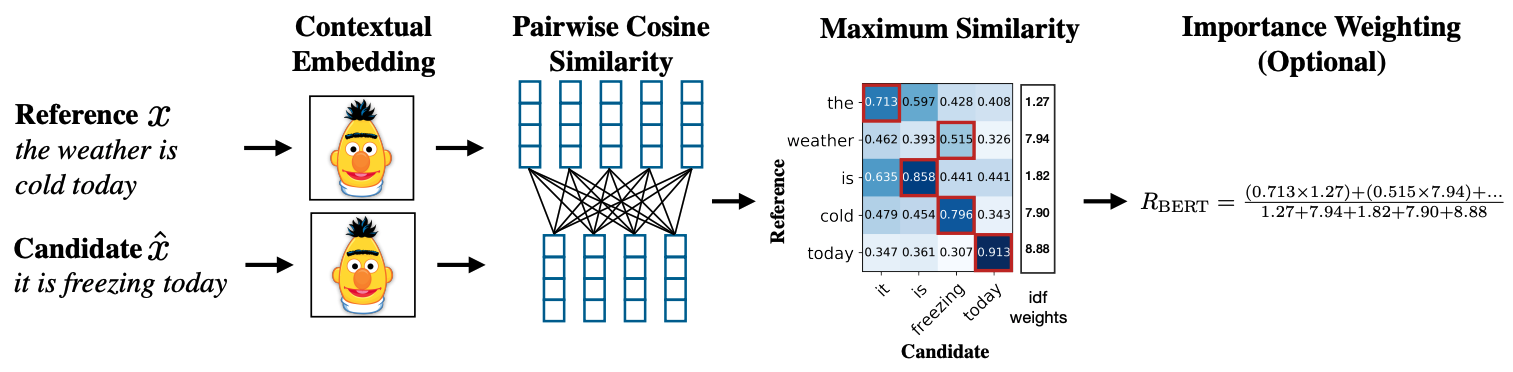

Either the average similarity score is computed over the reference or prediction words, respectively, or the scores are weighted by TF-IDF values and normalized to produce the final score. By default, the metric does not use TF-IDF values. The three scores to be reported are summarized below:

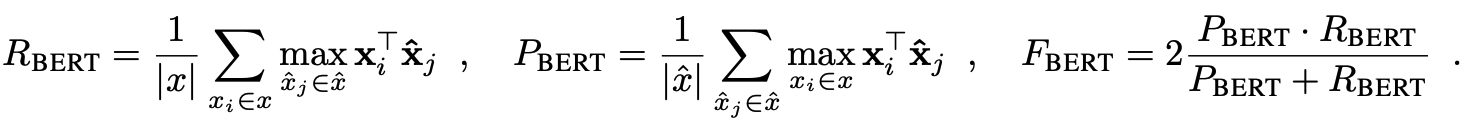

When computed over a dataset, the final dataset score is computed as the average BERTScore per example

In [ ]:
bertscore = evaluate.load("bertscore")
references = ["I like to run on trails in the Summer for exercise"]
predictions = ["I like to exercise on trails today"]
results = bertscore.compute(predictions=predictions, references=references, lang="en")
results